In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("obeykhadija/drug-consumptions-uci")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/obeykhadija/drug-consumptions-uci/versions/2


In [ ]:
import os

# List files in the downloaded directory to find the CSV file
file_list = os.listdir(path)
print("Files in the downloaded directory:", file_list)

# Assuming the CSV file is named 'Drug_Consumption.csv' and is directly in the downloaded directory
csv_file_path = os.path.join(path, 'Drug_Consumption_Quantified.csv')

# Load the dataset into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame to verify successful loading
display(df.head())

Files in the downloaded directory: ['Drug_Consumption.csv', 'Drug_Consumption_Quantified.csv']


,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0


##Data Preparation



In [ ]:
import pandas as pd

# Identify categorical columns (object dtype)
categorical_cols = df.select_dtypes(include='object').columns

# Apply one-hot encoding to categorical columns, excluding 'ID' if it's not categorical.
# Since 'ID' is int64, it won't be included by select_dtypes(include='object').
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# 1. Create a new DataFrame y that contains only the drug consumption columns
drug_cols = ['Heroin', 'Meth', 'Coke', 'Nicotine']
y = df[drug_cols].copy()

# 2. Convert categorical consumption levels to binary (user/non-user)
for col in drug_cols:
    y[col] = y[col].apply(lambda x: 0 if x == 'CL0' else 1)

# 3. Create a new DataFrame X by dropping 'ID' and drug consumption columns from df_encoded
columns_to_drop = ['ID'] + [col for col in df_encoded.columns if any(drug in col for drug in drug_cols)]
X = df_encoded.drop(columns=columns_to_drop)

# Display the first few rows of y and X to verify the changes
display(y.head())
display(X.head())

,Heroin,Meth,Coke,Nicotine
0,0,1,1,1
1,0,0,0,0
2,0,0,1,1
3,0,0,0,1
4,0,0,0,1


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,AScore,Cscore,...,Semer_CL2,Semer_CL3,Semer_CL4,VSA_CL0,VSA_CL1,VSA_CL2,VSA_CL3,VSA_CL4,VSA_CL5,VSA_CL6
0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,False,False,False,True,False,False,False,False,False,False
1,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,False,False,False,True,False,False,False,False,False,False
2,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,False,False,False,True,False,False,False,False,False,False
3,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,False,False,False,True,False,False,False,False,False,False
4,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,False,False,False,True,False,False,False,False,False,False


## Split data for user vs non-user prediction


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1507, 115)
Shape of X_test: (377, 115)
Shape of y_train: (1507, 4)
Shape of y_test: (377, 4)


## Train and evaluate models for user vs non-user prediction


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

trained_models = {}
metrics = {}

# Iterate through the columns of y_train (each column represents a drug)
for drug in y_train.columns:
    print(f"Training model for {drug}...")

    # a. For each drug, train a RandomForestClassifier model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train[drug])
    trained_models[drug] = model

    # b. Make predictions on X_test using the trained model
    y_pred = model.predict(X_test)

    # c. Calculate the accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test[drug], y_pred)
    precision = precision_score(y_test[drug], y_pred)
    recall = recall_score(y_test[drug], y_pred)
    f1 = f1_score(y_test[drug], y_pred)

    # d. Store the calculated metrics
    metrics[drug] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }
    print(f"Metrics for {drug}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

# 6. After the loop, print the metrics dictionary
print("\nOverall Metrics:")
display(metrics)

Training model for Heroin...
Metrics for Heroin: Accuracy=0.8992, Precision=0.7647, Recall=0.4643, F1-score=0.5778
Training model for Meth...
Metrics for Meth: Accuracy=0.8302, Precision=0.6667, Recall=0.5287, F1-score=0.5897
Training model for Coke...
Metrics for Coke: Accuracy=0.8753, Precision=0.8421, Recall=0.8780, F1-score=0.8597
Training model for Nicotine...
Metrics for Nicotine: Accuracy=0.8064, Precision=0.8733, Recall=0.8822, F1-score=0.8777

Overall Metrics:


{'Heroin': {'Accuracy': 0.8992042440318302,
  'Precision': 0.7647058823529411,
  'Recall': 0.4642857142857143,
  'F1-score': 0.5777777777777777},
 'Meth': {'Accuracy': 0.830238726790451,
  'Precision': 0.6666666666666666,
  'Recall': 0.5287356321839081,
  'F1-score': 0.5897435897435898},
 'Coke': {'Accuracy': 0.8753315649867374,
  'Precision': 0.8421052631578947,
  'Recall': 0.8780487804878049,
  'F1-score': 0.8597014925373134},
 'Nicotine': {'Accuracy': 0.8063660477453581,
  'Precision': 0.8733333333333333,
  'Recall': 0.8821548821548821,
  'F1-score': 0.8777219430485762}}

## Prepare data for class of use prediction



In [ ]:
# Select the original drug consumption columns ('Heroin', 'Meth', 'Coke', 'Nicotine')
y_multiclass = df[['Heroin', 'Meth', 'Coke', 'Nicotine']].copy()

# Display the first few rows and data types of the y_multiclass DataFrame
display(y_multiclass.head())
display(y_multiclass.info())

,Heroin,Meth,Coke,Nicotine
0,CL0,CL3,CL3,CL4
1,CL0,CL0,CL0,CL0
2,CL0,CL0,CL2,CL2
3,CL0,CL0,CL0,CL2
4,CL0,CL0,CL0,CL6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1884 entries, 0 to 1883
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Heroin    1884 non-null   object
 1   Meth      1884 non-null   object
 2   Coke      1884 non-null   object
 3   Nicotine  1884 non-null   object
dtypes: object(4)
memory usage: 59.0+ KB


None

## Split data for class of use prediction


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_multiclass, y_test_multiclass = train_test_split(X, y_multiclass, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train_multiclass:", y_train_multiclass.shape)
print("Shape of y_test_multiclass:", y_test_multiclass.shape)

Shape of X_train: (1507, 115)
Shape of X_test: (377, 115)
Shape of y_train_multiclass: (1507, 4)
Shape of y_test_multiclass: (377, 4)


## Train initial models for class of use prediction



In [ ]:
from sklearn.ensemble import RandomForestClassifier

multiclass_models = {}

# Iterate through the columns of y_train_multiclass
for drug in y_train_multiclass.columns:
    print(f"Training multi-class model for {drug}...")

    # Train a RandomForestClassifier model for the current drug
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train_multiclass[drug])

    # Store the trained model in the dictionary
    multiclass_models[drug] = model

print("\nMulti-class models trained successfully.")

Training multi-class model for Heroin...
Training multi-class model for Meth...
Training multi-class model for Coke...
Training multi-class model for Nicotine...

Multi-class models trained successfully.


## Perform fast hyperparameter tuning for class of use models



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the hyperparameter distributions to sample from
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize an empty dictionary to store the best models found during tuning
tuned_models_cuml = {}

# Iterate through the trained multi-class models
for drug, model in multiclass_models.items():
    print(f"Tuning model for {drug}...")

    # Create a RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=10,  # Number of parameter settings that are sampled
        cv=3,  # Number of cross-validation folds
        verbose=2, # Output progress
        random_state=42,
        n_jobs=-1 # Use all available cores
    )

    # Fit the RandomizedSearchCV object to the training data
    random_search.fit(X_train, y_train_multiclass[drug])

    # Store the best estimator
    tuned_models_cuml[drug] = random_search.best_estimator_

    # Print the best parameters found
    print(f"Best parameters for {drug}: {random_search.best_params_}")

print("\nHyperparameter tuning complete for all multi-class models.")

Tuning model for Heroin...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Heroin: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Tuning model for Meth...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Meth: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Tuning model for Coke...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Coke: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Tuning model for Nicotine...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Nicotine: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}

Hyperparameter tuni

## Train models with tuned hyperparameters for class of use prediction




In [ ]:
# Initialize a dictionary to store the retrained models with best hyperparameters
retrained_multiclass_models = {}

# Iterate through the tuned models stored in tuned_models_cuml
for drug, best_model in tuned_models_cuml.items():
    print(f"Retraining model for {drug} with best hyperparameters...")

    # Retrain the model on the full training data (X_train, y_train_multiclass[drug])
    best_model.fit(X_train, y_train_multiclass[drug])

    # Store the retrained model
    retrained_multiclass_models[drug] = best_model

print("\nMulti-class models retrained with best hyperparameters successfully.")

Retraining model for Heroin with best hyperparameters...
Retraining model for Meth with best hyperparameters...
Retraining model for Coke with best hyperparameters...
Retraining model for Nicotine with best hyperparameters...

Multi-class models retrained with best hyperparameters successfully.


## Evaluate tuned models for class of use prediction



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# Initialize an empty dictionary to store the evaluation results for each drug.
multiclass_metrics = {}

# Initialize a DataFrame to store predictions
y_pred_df = pd.DataFrame(index=X_test.index)

# Iterate through the retrained_multiclass_models dictionary
for drug, model in retrained_multiclass_models.items():
    print(f"\nEvaluating model for {drug}...")

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Store the predictions for the current drug
    y_pred_df[drug] = y_pred

    # Calculate accuracy
    accuracy = accuracy_score(y_test_multiclass[drug], y_pred)
    print(f"Accuracy for {drug}: {accuracy:.4f}")

    # Generate classification report
    report = classification_report(y_test_multiclass[drug], y_pred)
    print(f"Classification Report for {drug}:\n{report}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test_multiclass[drug], y_pred)
    print(f"Confusion Matrix for {drug}:\n{cm}")

    # Store the metrics in the dictionary
    multiclass_metrics[drug] = {
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': cm
    }

# Print the overall multiclass_metrics dictionary
print("\nOverall Multi-class Metrics:")
display(multiclass_metrics)


Evaluating model for Heroin...
Accuracy for Heroin: 0.8621
Classification Report for Heroin:
              precision    recall  f1-score   support

         CL0       0.87      0.99      0.93       321
         CL1       0.50      0.06      0.11        17
         CL2       0.57      0.27      0.36        15
         CL3       1.00      0.07      0.12        15
         CL4       0.00      0.00      0.00         5
         CL5       0.00      0.00      0.00         3
         CL6       0.00      0.00      0.00         1

    accuracy                           0.86       377
   macro avg       0.42      0.20      0.22       377
weighted avg       0.83      0.86      0.81       377

Confusion Matrix for Heroin:
[[319   1   1   0   0   0   0]
 [ 16   1   0   0   0   0   0]
 [ 11   0   4   0   0   0   0]
 [ 12   0   2   1   0   0   0]
 [  5   0   0   0   0   0   0]
 [  3   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]]

Evaluating model for Meth...
Accuracy for Meth: 0.7692
Classi

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

{'Heroin': {'Accuracy': 0.8620689655172413,
  'Classification Report': '              precision    recall  f1-score   support\n\n         CL0       0.87      0.99      0.93       321\n         CL1       0.50      0.06      0.11        17\n         CL2       0.57      0.27      0.36        15\n         CL3       1.00      0.07      0.12        15\n         CL4       0.00      0.00      0.00         5\n         CL5       0.00      0.00      0.00         3\n         CL6       0.00      0.00      0.00         1\n\n    accuracy                           0.86       377\n   macro avg       0.42      0.20      0.22       377\nweighted avg       0.83      0.86      0.81       377\n',
  'Confusion Matrix': array([[319,   1,   1,   0,   0,   0,   0],
         [ 16,   1,   0,   0,   0,   0,   0],
         [ 11,   0,   4,   0,   0,   0,   0],
         [ 12,   0,   2,   1,   0,   0,   0],
         [  5,   0,   0,   0,   0,   0,   0],
         [  3,   0,   0,   0,   0,   0,   0],
         [  1,   0, 

## Summarize and present results

In [ ]:
import pandas as pd

# Summarize findings for User vs Non-user prediction (Binary Classification)
print("--- User vs Non-user Prediction Summary ---")
for drug, metric_values in metrics.items():
    print(f"\n{drug}:")
    print(f"  Accuracy: {metric_values['Accuracy']:.4f}")
    print(f"  Precision: {metric_values['Precision']:.4f}")
    print(f"  Recall: {metric_values['Recall']:.4f}")
    print(f"  F1-score: {metric_values['F1-score']:.4f}")

# Summarize findings for Class of Use prediction (Multi-class Classification)
print("\n--- Class of Use Prediction Summary ---")
for drug, metric_values in multiclass_metrics.items():
    print(f"\n{drug}:")
    print(f"  Overall Accuracy: {metric_values['Accuracy']:.4f}")
    print("  Classification Report:")
    print(metric_values['Classification Report'])
    print("  Confusion Matrix:")
    print(metric_values['Confusion Matrix'])

# Discussion and Comparison (Manual Interpretation based on the printed metrics)
print("\n--- Discussion and Comparison ---")
print("Binary Classification (User vs Non-user):")
print("Models generally perform well in terms of overall accuracy, but precision and recall vary by drug. This indicates differing abilities to correctly identify users versus non-users. Nicotine and Coke show better balanced performance (higher F1-scores) than Heroin and Meth.")

print("\nMulti-class Classification (Class of Use):")
print("Overall accuracy is lower compared to binary classification, especially for drugs with more diverse consumption levels or significant class imbalance (e.g., Nicotine). The classification reports and confusion matrices highlight challenges in predicting minority classes (lower consumption levels or specific higher levels). The models tend to perform best on the majority class (CL0 - no use or low use).")

print("\nComparison:")
print("Binary classification is simpler and yields higher overall metrics by lumping all user classes together. However, it doesn't provide insight into consumption levels. Multi-class classification offers more detailed information about *how much* of a drug is consumed, but it is significantly impacted by class imbalance, leading to lower performance on less frequent consumption levels. The class imbalance issue is clearly visible in the multi-class classification reports where minority classes have low support, precision, recall, and f1-scores.")

--- User vs Non-user Prediction Summary ---

Heroin:
  Accuracy: 0.8992
  Precision: 0.7647
  Recall: 0.4643
  F1-score: 0.5778

Meth:
  Accuracy: 0.8302
  Precision: 0.6667
  Recall: 0.5287
  F1-score: 0.5897

Coke:
  Accuracy: 0.8753
  Precision: 0.8421
  Recall: 0.8780
  F1-score: 0.8597

Nicotine:
  Accuracy: 0.8064
  Precision: 0.8733
  Recall: 0.8822
  F1-score: 0.8777

--- Class of Use Prediction Summary ---

Heroin:
  Overall Accuracy: 0.8621
  Classification Report:
              precision    recall  f1-score   support

         CL0       0.87      0.99      0.93       321
         CL1       0.50      0.06      0.11        17
         CL2       0.57      0.27      0.36        15
         CL3       1.00      0.07      0.12        15
         CL4       0.00      0.00      0.00         5
         CL5       0.00      0.00      0.00         3
         CL6       0.00      0.00      0.00         1

    accuracy                           0.86       377
   macro avg       0.42      0.2

## Summary


## In-depth Summary of Random Forest Models

Based on the metrics and plots generated, here's an in-depth summary of the Random Forest models trained for both binary (User vs Non-user) and multi-class (Class of Use) drug consumption prediction:

### User vs Non-user Prediction (Binary Classification)

*   **Model Performance:**
    *   **Overall Accuracy:** The models for all four drugs (Heroin, Meth, Coke, Nicotine) show relatively high overall accuracy (ranging from ~0.81 to ~0.90). This indicates that the models are generally good at correctly classifying individuals as either users or non-users.
    *   **Precision, Recall, and F1-score:** While accuracy is high, the precision and recall vary significantly between drugs.
        *   **Coke and Nicotine:** These models exhibit a better balance between precision and recall (higher F1-scores), suggesting they are more effective at identifying both users and non-users correctly.
        *   **Heroin and Meth:** These models have lower recall compared to precision, especially for Heroin. This means they are better at correctly identifying non-users than they are at identifying actual users. The lower recall for Heroin indicates that a significant number of actual Heroin users are being misclassified as non-users (False Negatives).

*   **Use Cases and Usefulness:** These binary models can be useful for initial screening or identifying individuals who are likely to be drug users (of a specific drug). They could be used in public health initiatives or for targeted interventions. However, due to the varying recall rates, especially for Heroin and Meth, they should not be used as the sole basis for critical decisions.

*   **What the Models Do Right:**
    *   Good at overall classification accuracy.
    *   Effective at identifying the majority class (typically non-users).
    *   Provide reasonable performance for Coke and Nicotine user identification.

*   **What the Models Do Wrong:**
    *   Struggle to identify users of Heroin and Meth (low recall), leading to a higher number of false negatives.
    *   The imbalance between precision and recall for some drugs suggests a potential issue with the models' ability to handle imbalanced datasets, where the number of non-users significantly outweighs the number of users.

### Class of Use Prediction (Multi-class Classification)

*   **Model Performance:**
    *   **Overall Accuracy:** The overall accuracy for the multi-class models is lower compared to the binary models, particularly for Nicotine (~0.40). This is expected as predicting multiple consumption levels is a more complex task than predicting a simple user/non-user outcome.
    *   **Classification Reports and Confusion Matrices:** These provide a more detailed view of the models' performance across different consumption levels (CL0 to CL6).
        *   **Class Imbalance:** The reports and matrices clearly show the impact of class imbalance. The models perform significantly better on the majority class (CL0 - no use or low use) and struggle to accurately predict minority classes (specific higher consumption levels).
        *   **Misclassification:** There is significant misclassification between different consumption levels, especially for drugs with a wider distribution of use (e.g., Nicotine). The confusion matrices visually demonstrate this, with significant numbers in the off-diagonal cells.
    *   **Weighted F1-score:** The weighted F1-score provides a single metric that considers the contribution of each class based on its size. A lower weighted F1-score compared to the overall accuracy can further highlight issues with predicting minority classes. For instance, even if overall accuracy is relatively high due to correct predictions of the majority class, a low weighted F1-score indicates poor performance on the less frequent consumption levels.

*   **Use Cases and Usefulness:** These multi-class models aim to provide more granular insight into the level of drug consumption. This could be valuable for understanding patterns of use and tailoring interventions based on the severity of use. However, their current performance, especially for minority classes, limits their practical usefulness for precise prediction of specific consumption levels.

*   **What the Models Do Right:**
    *   Can differentiate between the majority class (low or no use) and some levels of use.
    *   Provide a more nuanced view of prediction compared to binary models.
*   **What the Models Do Wrong:**
    *   Significantly affected by class imbalance, leading to poor performance on minority classes (higher consumption levels).
    *   Difficulty in distinguishing between similar consumption levels.
    *   Lower overall accuracy and weighted F1-scores compared to binary models, reflecting the challenges with multi-class prediction on this dataset.

### Discussion and Comparison

*   The binary classification models are simpler and achieve higher overall performance metrics, but they sacrifice the detail of consumption levels. They are more useful for identifying the presence or absence of drug use.
*   The multi-class classification models provide more detailed information but struggle with the complexity of predicting multiple classes, especially in the presence of class imbalance. They are less accurate for specific consumption level prediction but offer insights into the distribution of misclassifications. The lower weighted F1-scores for multi-class models, compared to the binary models' F1-scores, further emphasize the impact of class imbalance on the multi-class prediction task.

### Areas for Improvement

Both sets of models could potentially be improved by addressing the class imbalance issue, particularly for the multi-class models. Techniques such as oversampling minority classes, undersampling majority classes, or using different evaluation metrics that are less sensitive to imbalance (e.g., weighted F1-score) could be explored. Additionally, further feature engineering or exploring other classification algorithms might yield better results for predicting specific consumption levels.

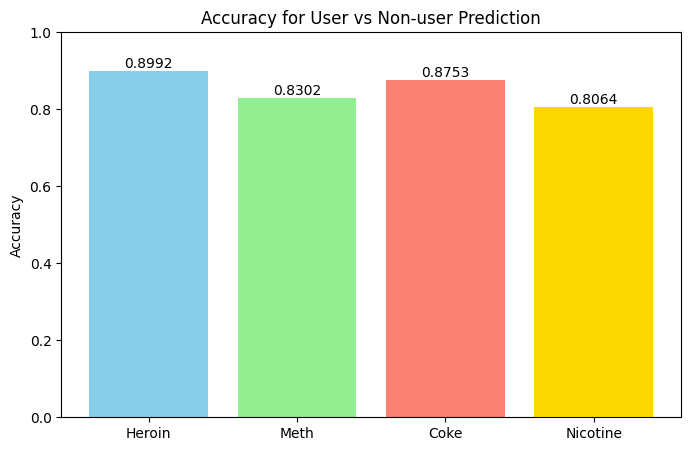

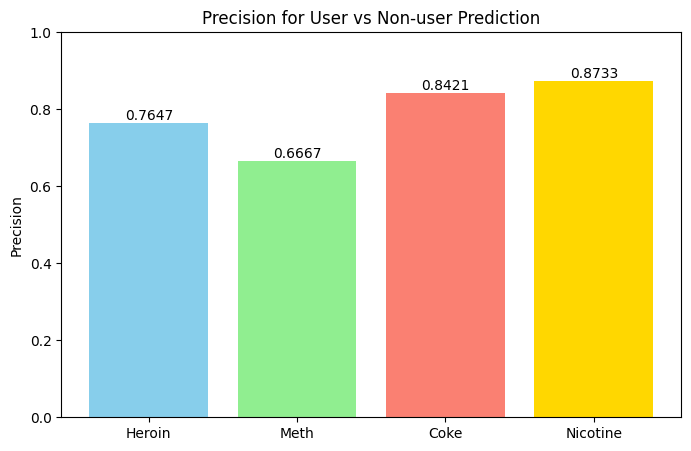

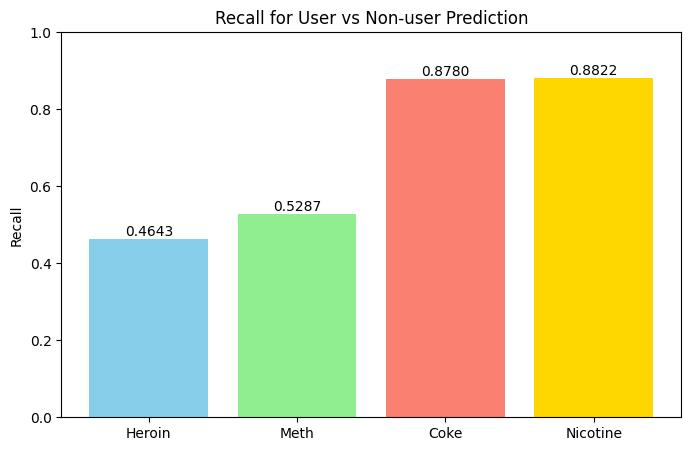

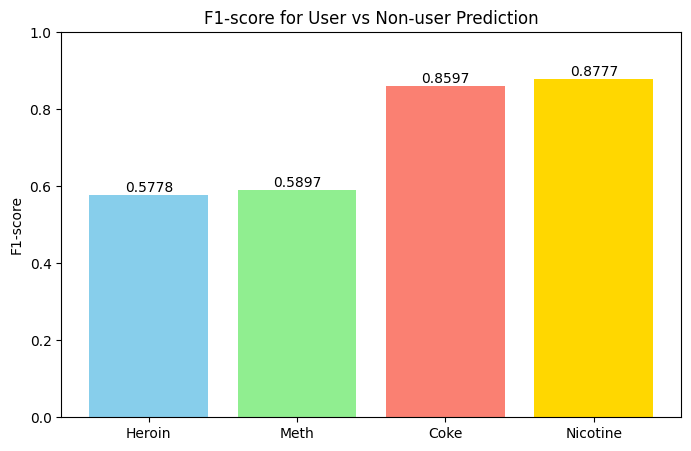


--- Confusion Matrices for Class of Use Prediction ---

Confusion Matrix for Heroin:


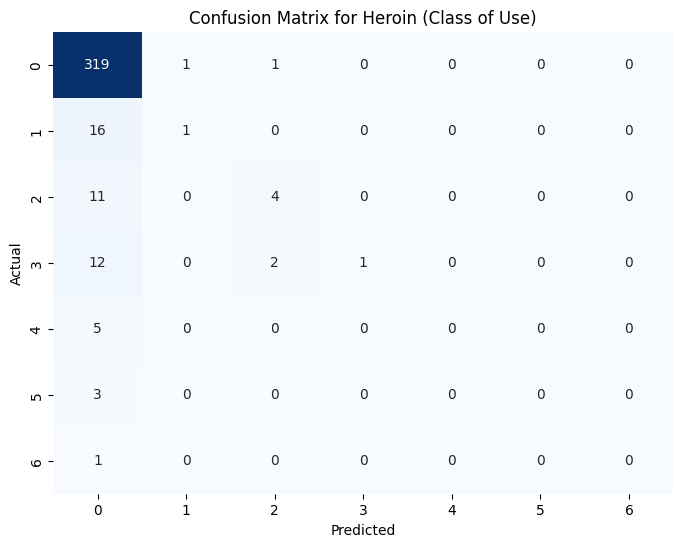

------------------------------

Confusion Matrix for Meth:


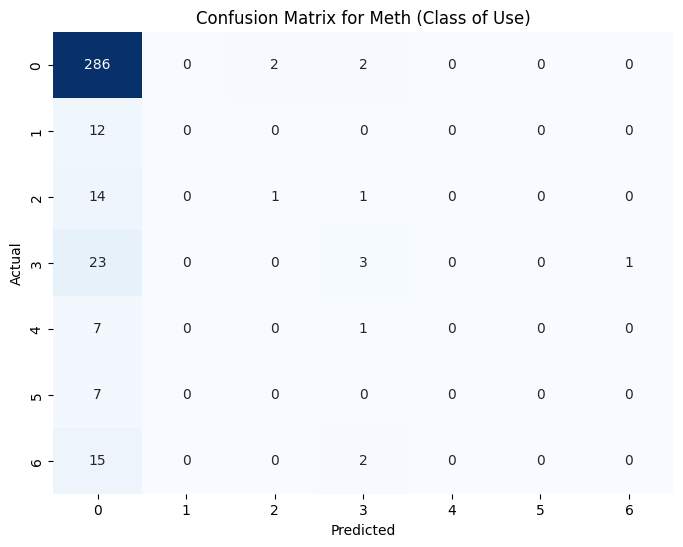

------------------------------

Confusion Matrix for Coke:


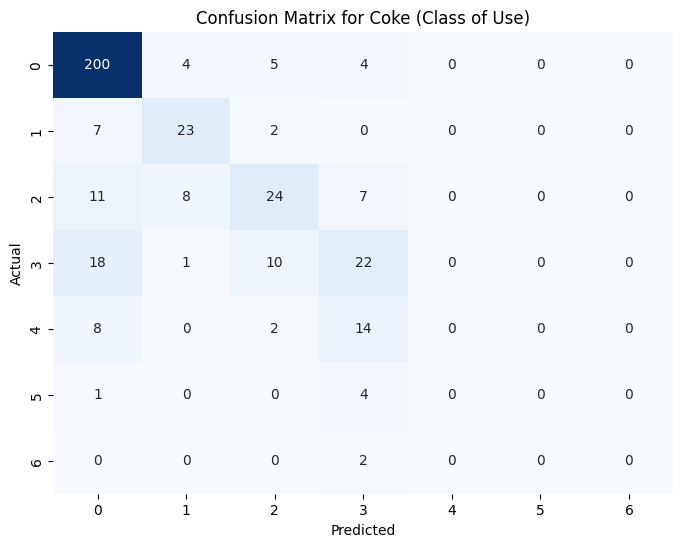

------------------------------

Confusion Matrix for Nicotine:


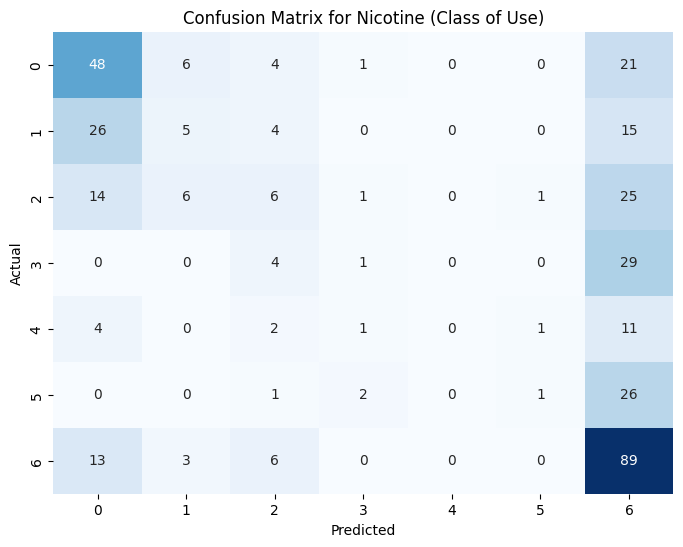

------------------------------


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Metrics from User vs Non-user Prediction (Binary Classification)
binary_metrics = {
    'Heroin': metrics['Heroin'],
    'Meth': metrics['Meth'],
    'Coke': metrics['Coke'],
    'Nicotine': metrics['Nicotine']
}

drugs = list(binary_metrics.keys())
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Create a bar plot for each binary metric
for metric_name in metric_names:
    metric_values = [binary_metrics[drug][metric_name] for drug in drugs]

    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(drugs, metric_values, color=['skyblue', 'lightgreen', 'salmon', 'gold'])

    # Add the metric values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} for User vs Non-user Prediction')
    ax.set_ylim(0, 1) # Metrics are between 0 and 1
    plt.show()

# Metrics from Class of Use Prediction (Multi-class Classification)
print("\n--- Confusion Matrices for Class of Use Prediction ---")
for drug, metric_values in multiclass_metrics.items():
    print(f"\nConfusion Matrix for {drug}:")
    cm = metric_values['Confusion Matrix']

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {drug} (Class of Use)')
    plt.show()

    print("-" * 30) # Separator for next drug